[github url]<br>
https://github.com/comeeasy/SMU-DeepLearning-prac

In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# 1. MNIST train, test dataset 가져오기

In [50]:
# "": 현재 폴더에 MNIST 있음
mnist_train = dset.MNIST(root="../",
                         train=True,
                         transform=transforms.ToTensor(),
                         target_transform=None,
                         download=True)
mnist_test  = dset.MNIST(root="../",
                         train=False,
                         transform=transforms.ToTensor(),
                         target_transform=None,
                         download=True)

# 2. 대략적인 데이터 형태

mnist_train 길이:60000
mnist_test  길이:10000
image data 형태:torch.Size([1, 1, 28, 28])
label:5
torch.Size([1, 3, 28, 28])


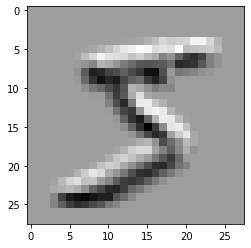

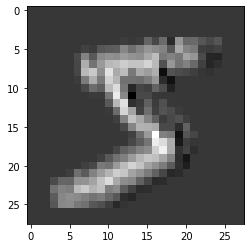

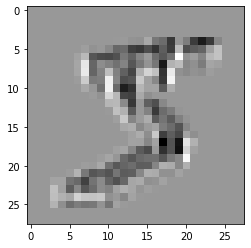

In [51]:
print(f'mnist_train 길이:{len(mnist_train)}')
print(f'mnist_test  길이:{len(mnist_test)}')

# 데이터 하나 형태
image, label = mnist_train[0]

image = image.view(-1, image.shape[0], image.shape[1], image.shape[2])
print(f'image data 형태:{image.shape}')
print(f'label:{label}')

conv_layer = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding=1)
output = conv_layer(Variable(image))
print(output.shape)

# 그리기
for i in range(3):
    plt.imshow(output[0,i,:,:].data.numpy(), cmap='gray')
    plt.show()

# 3. 데이터 로드 함수

In [52]:
# hyper parameter
batch_size = 512
learning_rate = 1e-2
epochs = 10

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'[INFO] train with {device}')

train_loader = DataLoader(dataset=mnist_train,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2,
                          drop_last=True)
test_loader  = DataLoader(dataset=mnist_test,
                          batch_size=batch_size,
                          shuffle=False,
                          num_workers=2,
                          drop_last=True)

[INFO] train with cuda


# 4. 모델 선언

![model](./model.PNG)

In [53]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer = nn.Sequential( # 28x28
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.ReLU(),  # 28x28

            nn.Conv2d(16, 32, kernel_size=5, padding=2),    # 28x28
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 28x28 -> 14x14

            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 100),
            nn.ReLU(),
            nn.Linear(100, 10)
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)

    def forward(self, x):
        x = self.layer(x)
        x = self.fc_layer(x)

        return x

# parameter 보기
model = CNN().to(device=device)

for parameter in model.parameters():
    print(parameter.shape)
    print(parameter)

torch.Size([16, 1, 5, 5])
Parameter containing:
tensor([[[[ 0.3477, -0.2549,  0.3149, -0.0760,  0.2889],
          [ 0.1739,  0.0994, -0.3574, -0.1696,  0.2085],
          [-0.2663, -0.0330,  0.4497,  0.3335, -0.3562],
          [-0.2653,  0.4209,  0.2412, -0.1440,  0.1072],
          [-0.2321,  0.3654,  0.2025, -0.3314,  0.0728]]],


        [[[ 0.5289, -0.2120, -0.2816, -0.2269, -0.0784],
          [-0.0508,  0.2114,  0.2333, -0.8355, -0.1889],
          [ 0.2576, -0.2411,  0.3123, -0.3593,  0.1321],
          [-0.3404, -0.3760,  0.0565, -0.0307,  0.3837],
          [-0.1449,  0.4387,  0.0376,  0.1666, -0.0381]]],


        [[[-0.2660, -0.1586, -0.2081, -0.2058,  0.1966],
          [-0.6897,  0.2485, -0.3049,  0.1780, -0.1183],
          [ 0.2147, -0.1196,  0.0624, -0.0805,  0.2146],
          [-0.4773,  0.1303,  0.0746,  0.2942,  0.0622],
          [-0.4449, -0.1432,  0.3478,  0.3304,  0.0920]]],


        [[[-0.1600, -0.2839,  0.1711,  0.1169, -0.5632],
          [-0.0806, -0.2434,

## optimizer

In [54]:
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## train

In [55]:
def compute_acc(dloader=None, model=None):
    model.eval()

    correct = 0
    total = 0

    for i, [imgs, labels] in enumerate(dloader):
        img = imgs.to(device)
        label = Variable(labels).to(device)

        output = model(img)
        _, output_index = torch.max(output, 1)

        total += label.size(0)
        correct += (output_index == label).sum().float()

    print(f'Accuracy of Test Data: {100 * correct/total}')

In [ ]:
from tqdm import tqdm

for i in tqdm(range(epochs+1)):
    model.train()

    for j, [imgs, labels] in enumerate(train_loader):
        img = imgs.to(device)
        label = Variable(labels).to(device)

        # img = img.view(img.shape[0], img.shape[2] * img.shape[3])
        # img = Variable(img, requires_grad=False).to(device)

        optimizer.zero_grad()
        output = model(img)
        loss = loss_fn(output, label)

        loss.backward()
        optimizer.step()

    print(i, loss)

torch.save(model, './weights/mycnn.pkl')
print(f'model saved in ./weights/mycnn.pkl')


 18%|█▊        | 2/11 [00:11<00:50,  5.63s/it]

0 tensor(0.0514, device='cuda:0', grad_fn=<NllLossBackward>)
1 tensor(0.0426, device='cuda:0', grad_fn=<NllLossBackward>)


In [ ]:
try:
    model_trained = torch.load('./weights/mycnn.pkl')
    compute_acc(test_loader, model_trained)
except:
    print('model not restored')